In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import urllib
import json
import os, glob
import warpImage
from pointAnnotator import pointAnnotator, pointCopier
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib notebook

In [7]:
localWarp=False
%matplotlib notebook #for some reason, I find you have to run this line twice to actually take effect (depending on matplotlib version)

In [3]:
#get path to network folder with lims images for this mouse
mouse_num = '421323'
json_string = urllib.urlopen("http://lims2/specimens/isi_experiment_details/" + mouse_num + ".json").read()
info = json.loads(json_string)
vimg_path = r'\\' + info[0]['target_map_image_path'][1:]
print(vimg_path)

\\allen/programs/braintv/production/visualbehavior/prod0/specimen_769292015/isi_experiment_777042004/777042004_target_map.tif


In [4]:
#get vasculature image
vimg = cv2.imread(vimg_path)

#get probe insertion image
pimgFileName = r'Z:\04252019\2019_04_25_15_42_16_left.png'
pimg = cv2.imread(pimgFileName)

#change from opencv bgr default back to rgb
pimg = pimg[:, :, [2,1,0]]
vimg = vimg[:, :, [2,1,0]]
aspect = (pimg.shape[0]+vimg.shape[0])/float(np.max([pimg.shape[1], vimg.shape[1]]))

<IPython.core.display.Javascript object>


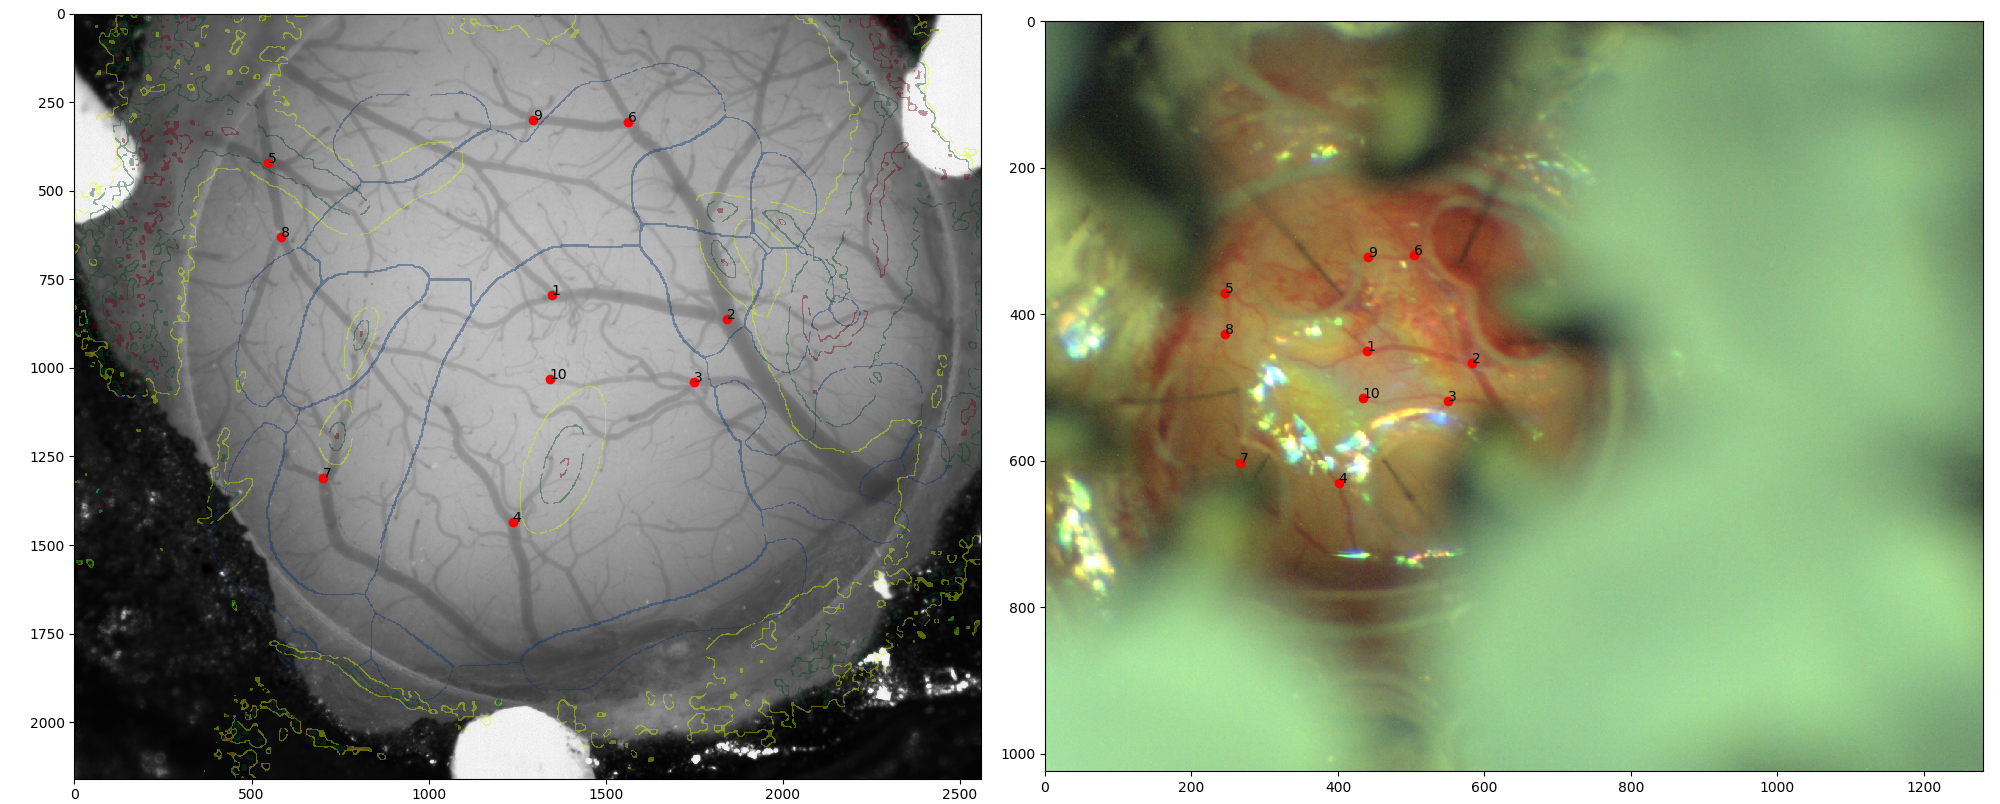

In [8]:
#Display the vasculature image and select points of interest (at least three)
fig, ax = plt.subplots(1,2, figsize=(20,20/(2*aspect)))
vax = ax[0]
pax = ax[1]

vim = vax.imshow(vimg, origin='upper')
vpa = pointAnnotator(vim, vax)
#vpa.loadPoints(vpoints)

pim = pax.imshow(pimg, origin='upper')
ppa = pointAnnotator(pim, pax)

plt.tight_layout(pad=1, w_pad=0, h_pad=0)

<IPython.core.display.Javascript object>


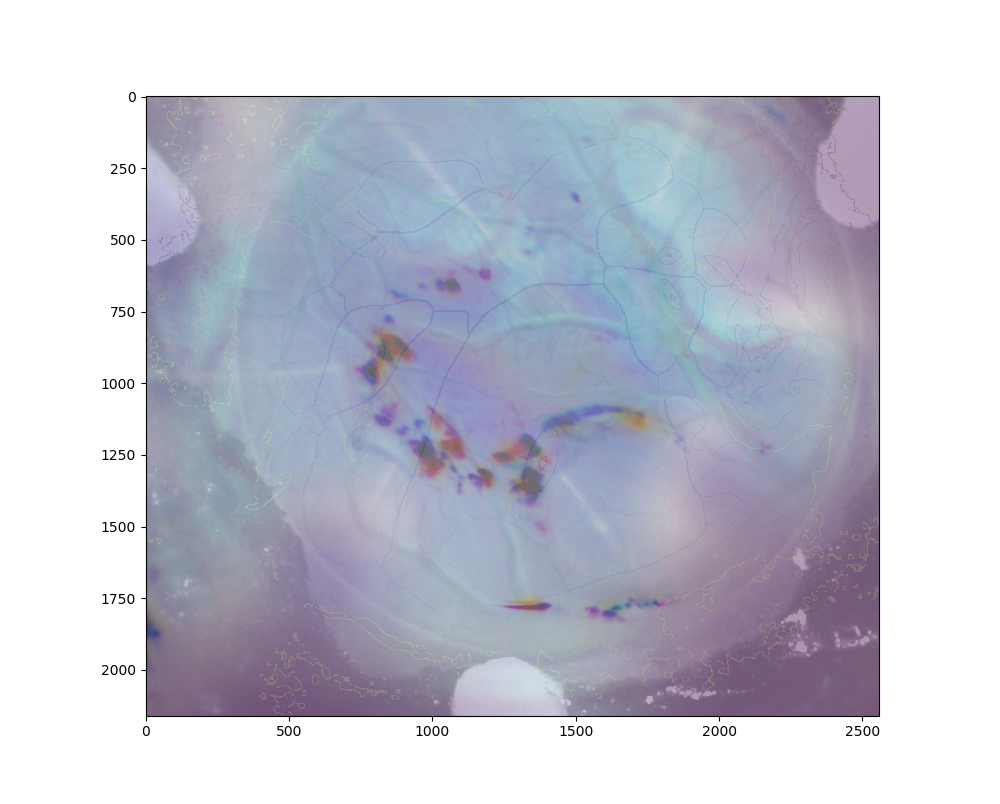

In [9]:
#Compute affine transform to warp probe insertion image to vasculature image coordinates

#reshape points into [numpoints, 2] arrays
ppoints = np.stack((ppa.xs, ppa.ys)).astype(np.float32).T
vpoints = np.stack((vpa.xs, vpa.ys)).astype(np.float32).T

#get perspective transform between images and apply it to probe insertion image
perspective = cv2.findHomography(ppoints, vpoints)
pimg_transform = cv2.warpPerspective(pimg, perspective[0], (vimg.shape[1], vimg.shape[0]))

#transform probe insertion points to use in local warping or plot on transformed image
ppoints_transform = cv2.perspectiveTransform(np.array([ppoints.astype(np.float32)]), perspective[0])
ppoints_transform = np.squeeze(ppoints_transform)

#perform Delaunay triangle local warp if specified
if localWarp:
    pimg_transform = warpImage.warpImage(vimg, pimg_transform, vpoints, ppoints_transform)

#plot overlay of vasculature image and transformed image to compare
fig, ax = plt.subplots(figsize=(10,10/aspect))
ax.imshow(vimg, alpha=0.5)
ax.imshow(255-pimg_transform, alpha=0.5)


In [12]:
#Select location of probe insertion points in this warped image
fig, ax = plt.subplots(1,2, figsize=(20,20/(2*aspect)))
paffax = ax[0]
vax = ax[1]

paff_im = paffax.imshow(pimg_transform, origin='upper')
paffp = pointAnnotator(paff_im, paffax)
paffpoints = np.stack((paffp.xs, paffp.ys)).astype(np.float32).T

vim = vax.imshow(vimg, origin='upper')
vpa = pointCopier(vim, vax)




<IPython.core.display.Javascript object>

In [13]:
# save points and transformation matrix
saveDirectory = os.path.dirname(pimgFileName)
np.save(os.path.join(saveDirectory,'vasculatureImageKeypoints.npy'), vpoints)
np.save(os.path.join(saveDirectory,'probeImageKeypoints.npy'), ppoints)
np.save(os.path.join(saveDirectory, 'vasculatureToProbeInsertionTransform.npy'), perspective[0])
np.save(os.path.join(saveDirectory, 'probeInsertionPointsTransformed.npy'), paffpoints)

In [14]:
# save notebook as html
saveDirectory = os.path.dirname(pimgFileName)
os.system('jupyter nbconvert probeInsertionLocator.ipynb --output ' + os.path.join(saveDirectory, 'probeInsertionNotebook.html'))

0